In [61]:
import scanpy as sc, numpy as np, pandas as pd
import os, re, glob2, anndata as ad
import seaborn as sns

In [62]:
from collections import Counter

In [63]:
from matplotlib import pyplot as plt
from upsetplot import plot, from_contents

In [4]:
def ret_intersections(SID_cs, SID_ms, SID_hd, SID_vireo):
    concur = []
    for i in range(SID_cs.shape[0]):
        if not(SID_vireo[i].startswith('donor')) and SID_vireo[i] != "Not in Vireo":
            if SID_cs[i] == SID_ms[i] and SID_cs[i] == SID_hd[i] and SID_cs[i] == SID_vireo[i]:
                concur.append("All")
            elif SID_cs[i] == SID_ms[i] and SID_cs[i] != SID_hd[i] and SID_cs[i] != SID_vireo[i]:
                concur.append("CS_MS")
            elif SID_cs[i] == SID_hd[i] and SID_cs[i] != SID_ms[i] and SID_cs[i] != SID_vireo[i]:
                concur.append("CS_HD")
            elif SID_cs[i] == SID_vireo[i] and SID_cs[i] != SID_hd[i] and SID_cs[i] != SID_ms[i]:
                concur.append("CS_vireo")
            elif SID_ms[i] == SID_hd[i] and SID_ms[i] != SID_cs[i] and SID_ms[i] != SID_vireo[i]:
                concur.append("MS_HD")
            elif SID_ms[i] == SID_vireo[i] and SID_ms[i] != SID_hd[i] and SID_ms[i] != SID_cs[i]:
                concur.append("MS_vireo")
            elif SID_hd[i] == SID_vireo[i] and SID_hd[i] != SID_cs[i] and SID_hd[i] != SID_cs[i]:
                concur.append("HD_vireo")
            elif SID_cs[i] == SID_ms[i] and SID_cs[i] == SID_hd[i] and SID_cs[i] != SID_vireo[i]:
                concur.append("CS_MS_HD")
            elif SID_cs[i] == SID_vireo[i] and SID_cs[i] == SID_hd[i] and SID_cs[i] != SID_ms[i]:
                concur.append("CS_HD_vireo")
            elif SID_cs[i] == SID_ms[i] and SID_cs[i] == SID_vireo[i] and SID_cs[i] != SID_hd[i]:
                concur.append("CS_MS_vireo")
            elif SID_ms[i] == SID_hd[i] and SID_ms[i] == SID_vireo[i] and SID_ms[i] != SID_cs[i]:
                concur.append("MS_HD_vireo")
            else:
                concur.append("No_concurrence")
        elif SID_vireo[i].startswith('donor'):
            if SID_cs[i] == SID_ms[i] and SID_cs[i] == SID_hd[i]:
                concur.append("No_gt_All")
            elif SID_cs[i] == SID_ms[i] and SID_cs[i] != SID_hd[i]:
                concur.append("No_gt_CS_MS")
            elif SID_cs[i] == SID_hd[i] and SID_cs[i] != SID_ms[i]:
                concur.append("No_gt_CS_HD")
            elif SID_ms[i] == SID_hd[i] and SID_ms[i] == SID_cs[i]:
                concur.append("No_gt_MS_HD")
            else:
                concur.append("No_gt_No_concurrence")
        else: # Case: Not in vireo
            if SID_cs[i] == SID_ms[i] and SID_cs[i] == SID_hd[i]:
                concur.append("No_vireo_All")
            elif SID_cs[i] == SID_ms[i]:
                concur.append("No_vireo_CS_MS")
            elif SID_cs[i] == SID_hd[i]:
                concur.append("No_vireo_CS_HD")
            elif SID_ms[i] == SID_hd[i]:
                concur.append("No_vireo_MS_HD")
            else:
                concur.append("No_vireo_No_concurrence")
    
    return concur
        

In [5]:
samp_l = ["round2_Sample-NPSAD-20201112-A1-cDNA", "round2_Sample-NPSAD-20201113-C1-cDNA", "round2_Sample-NPSAD-20201112-A2-cDNA", "round2_Sample-NPSAD-20201113-C2-cDNA", "round4_Sample-NPSAD-20210217-C1-cDNA", "round4_Sample-NPSAD-20210217-C2-cDNA", "round3_Sample-NPSAD-20201215-C1-cDNA", "round3_Sample-NPSAD-20201215-C2-cDNA", "round1_Sample-NPSAD-20201030-C1-cDNA", "round1_Sample-NPSAD-20201030-C2-cDNA"]

In [6]:
path_samp = ["/sc/arion/projects/psychAD/final_count_matrix/combo/" + s for s in samp_l] 

In [64]:
vireo_info = {s.split('_')[1].replace('Sample-', ''):pd.read_csv("/sc/arion/projects/psychAD/demux_gt/vireoSNP/" + s.split('_')[0] 
                          + '/' +s.split('_')[1].replace('Sample-', 'Sample_') + '/donor_ids.tsv', sep='\t') for s in samp_l}

In [8]:
vireo_info.keys()

dict_keys(['NPSAD-20201112-A1-cDNA', 'NPSAD-20201113-C1-cDNA', 'NPSAD-20201112-A2-cDNA', 'NPSAD-20201113-C2-cDNA', 'NPSAD-20210217-C1-cDNA', 'NPSAD-20210217-C2-cDNA', 'NPSAD-20201215-C1-cDNA', 'NPSAD-20201215-C2-cDNA', 'NPSAD-20201030-C1-cDNA', 'NPSAD-20201030-C2-cDNA'])

In [9]:
vireo_info['NPSAD-20201112-A1-cDNA'].head(3)

,cell,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet,doublet_logLikRatio
0,AAACCCAAGACCATAA,MSSM_202,1.000000e+00,1.240000e-08,191,MSSM_202,"MSSM_18,MSSM_202",-15.847
1,AAACCCAAGACTACCT,unassigned,8.920000e-01,2.930000e-02,17,donor5,"MSSM_91,donor4",-1.060
2,AAACCCAAGCACCGAA,doublet,3.440000e-09,1.000000e+00,218,MSSM_18,"MSSM_18,donor4",21.845


In [10]:
Counter(vireo_info['NPSAD-20201112-A1-cDNA']['donor_id'])

Counter({'MSSM_202': 4919,
         'unassigned': 2709,
         'doublet': 945,
         'donor4': 3313,
         'MSSM_18': 2434,
         'donor3': 3480,
         'MSSM_91': 947,
         'donor5': 389})

In [65]:
vireo_info_cr = {s.split('_')[1].replace('Sample-', ''):pd.read_csv("/sc/arion/projects/psychAD/demux_gt/vireoSNP/" + s.split('_')[0] 
                          + '/' +s.split('_')[1].replace('Sample-', 'Sample_') + '_cr/donor_ids.tsv', sep='\t') for s in samp_l}

In [66]:
vireo_info_cr.keys()

dict_keys(['NPSAD-20201112-A1-cDNA', 'NPSAD-20201113-C1-cDNA', 'NPSAD-20201112-A2-cDNA', 'NPSAD-20201113-C2-cDNA', 'NPSAD-20210217-C1-cDNA', 'NPSAD-20210217-C2-cDNA', 'NPSAD-20201215-C1-cDNA', 'NPSAD-20201215-C2-cDNA', 'NPSAD-20201030-C1-cDNA', 'NPSAD-20201030-C2-cDNA'])

In [68]:
for k, v in vireo_info_cr.items():
    v['cell'] = v['cell'].map(lambda x: x[:16])
    
vireo_info_cr['NPSAD-20201112-A1-cDNA'].head(3)

,cell,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet,doublet_logLikRatio
0,AAACCCAAGACCATAA,MSSM_202,1.000000,1.240000e-09,196,MSSM_202,"MSSM_91,MSSM_18",-18.172
1,AAACCCAAGACTACCT,unassigned,0.109000,2.250000e-01,20,MSSM_91,"MSSM_91,donor4",3.064
2,AAACCCAAGCACCGAA,doublet,0.000225,1.000000e+00,227,donor3,"MSSM_18,donor3",10.740


In [69]:
Counter(vireo_info_cr['NPSAD-20201112-A1-cDNA']['donor_id'])

Counter({'MSSM_202': 4942,
         'unassigned': 3074,
         'doublet': 995,
         'MSSM_18': 2780,
         'donor3': 2716,
         'donor5': 3465,
         'donor4': 461,
         'MSSM_91': 975})

In [27]:
hash_t = pd.read_csv('/sc/arion/projects/psychAD/pnm/Hash_map_gtID_SubID.csv')

In [28]:
hash_t.head(3)

,SubNum,SNP_report:Genotyping_Sample_ID,Samp_ID
0,M7718,MSSM_59,NPSAD-20210303-A
1,M79990,MSSM_54,NPSAD-20201221-A
2,M80700,MSSM_167,NaN


In [16]:
def ret_samp_names(y, v_f, h_t):
    #print(len(y), len(bc))
    if y[:16] in v_f['cell'].values:
        val = v_f.loc[v_f['cell'] == y[:16], 'donor_id'].values[0]
        if val.startswith('MSSM'):
            return h_t.loc[h_t['SNP_report:Genotyping_Sample_ID'] == val, 'SubNum'].values[0]
        
        elif val == 'doublet':
            return 'Doublet'
        
        elif val == 'unassigned':
            return 'Negative'
        
        else: # For donors without gt info
            return val

    else:
        return "Not in Vireo"


In [30]:
def anndata_out(file_pref, suff, vireo_out):
    ann_d = ad.read(file_pref+suff)
    samp_n = os.path.basename(file_pref).split('_')[1].replace('Sample-', '')
    ann_d.obs['SubID_vireo'] = ann_d.obs_names.to_series().apply(ret_samp_names, args=(vireo_out[samp_n], hash_t))
    ann_d.obs['batch_1'] = ann_d.obs['batch'].map(lambda x: x[:-6])
    return ann_d

In [31]:
adatas1 = [anndata_out(sample, "_STARsolo_combo_unfilt_out.h5ad", vireo_info) for sample in path_samp]

In [32]:
adata1 = ad.concat(adatas1[:], index_unique='-', keys=[s.split('_')[1].replace('Sample-', '') for s in samp_l], join='inner')

In [33]:
adata1

AnnData object with n_obs × n_vars = 167045 × 32405
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'set', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'SubID_vireo', 'batch_1'

In [34]:
Counter(adata1.obs['SubID_vireo'])

Counter({'M1176': 10101,
         'Negative': 15316,
         'Doublet': 9960,
         'donor4': 13005,
         'M76138': 4947,
         'donor3': 14557,
         'M45480': 1979,
         'donor5': 21654,
         'M44145': 5477,
         'M67780': 6396,
         'M48326': 3896,
         'M34836': 4782,
         'M8926': 3857,
         'M29736': 2215,
         'M30150': 5427,
         'M55245': 6222,
         'M24257': 7324,
         'M32215': 2585,
         'M84511': 11043,
         'M9161': 3514,
         'M11589': 5955,
         'M88010': 2737,
         'M26992': 4096})

For STARsolo output

... storing 'batch' as categorical
... storing 'prep' as categorical
... storing 'rep' as categorical
... storing 'set' as categorical
... storing 'SubID_hd' as categorical
... storing 'HTO_n_hd' as categorical
... storing 'SubID_cs' as categorical
... storing 'SubID_ms' as categorical
... storing 'HTO_n_cs' as categorical
... storing 'HTO_n_ms' as categorical
... storing 'SubID_vireo' as categorical
... storing 'batch_1' as categorical
/sc/arion/work/prashf01/conda/envs/snakemake/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


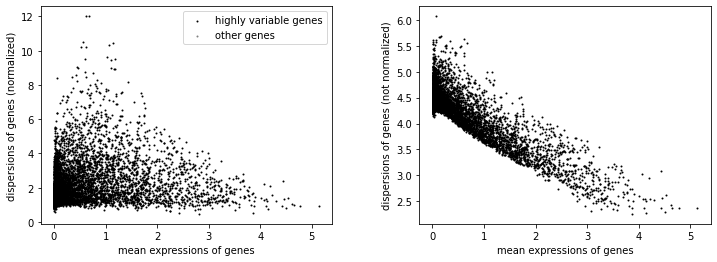

AnnData object with n_obs × n_vars = 167045 × 6000
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'set', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'SubID_vireo', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'


In [35]:

# Total-count normalize (library-size correct) the data matrix X to 1M i.e. CPM
sc.pp.normalize_total(adata1, target_sum=1e6)


# Logarithmize the data
sc.pp.log1p(adata1)

# Freeze the normalized data
adata1.raw = adata1

# Identify highly-variable genes, flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata1, n_top_genes=6000, flavor="cell_ranger", batch_key='batch', subset=True)
sc.pl.highly_variable_genes(adata1, save='_10sets_SS_HVG.png')

print(adata1)

In [36]:
# PCA
sc.tl.pca(adata1, svd_solver='arpack')
print("\t\t\tDone with pca")


# Run Harmony
sc.external.pp.harmony_integrate(adata1, 'batch', max_iter_harmony=20)


# Save to File
# adata.write(results_file)
print(adata1)



			Done with pca


2021-09-28 17:16:10,830 - harmonypy - INFO - Iteration 1 of 20
2021-09-28 17:17:27,210 - harmonypy - INFO - Iteration 2 of 20
2021-09-28 17:18:43,704 - harmonypy - INFO - Iteration 3 of 20
2021-09-28 17:20:00,302 - harmonypy - INFO - Iteration 4 of 20
2021-09-28 17:21:17,004 - harmonypy - INFO - Iteration 5 of 20
2021-09-28 17:22:33,776 - harmonypy - INFO - Iteration 6 of 20
2021-09-28 17:23:33,511 - harmonypy - INFO - Iteration 7 of 20
2021-09-28 17:24:02,413 - harmonypy - INFO - Iteration 8 of 20
2021-09-28 17:24:27,852 - harmonypy - INFO - Iteration 9 of 20
2021-09-28 17:24:53,347 - harmonypy - INFO - Iteration 10 of 20
2021-09-28 17:25:18,785 - harmonypy - INFO - Iteration 11 of 20
2021-09-28 17:25:44,311 - harmonypy - INFO - Iteration 12 of 20
2021-09-28 17:26:09,723 - harmonypy - INFO - Iteration 13 of 20
2021-09-28 17:26:35,159 - harmonypy - INFO - Iteration 14 of 20
2021-09-28 17:27:00,551 - harmonypy - INFO - Iteration 15 of 20
2021-09-28 17:27:26,183 - harmonypy - INFO - Iter

AnnData object with n_obs × n_vars = 167045 × 6000
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'set', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'SubID_vireo', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'


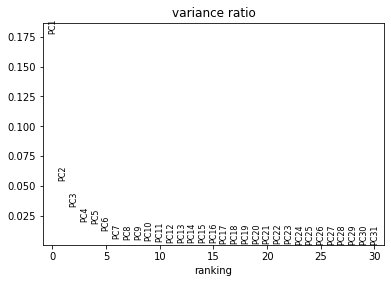

In [37]:
# Scree Plot
sc.pl.pca_variance_ratio(adata1, save='_10sets_SS_Scree_plot.png')

In [38]:
sc.pp.neighbors(adata1, use_rep='X_pca_harmony')
print("\t\t\tDone with calculating neighbours")

sc.tl.umap(adata1, min_dist=0.3)

sc.tl.leiden(adata1)


print(adata1)

			Done with calculating neighbours
AnnData object with n_obs × n_vars = 167045 × 6000
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'set', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'SubID_vireo', 'batch_1', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


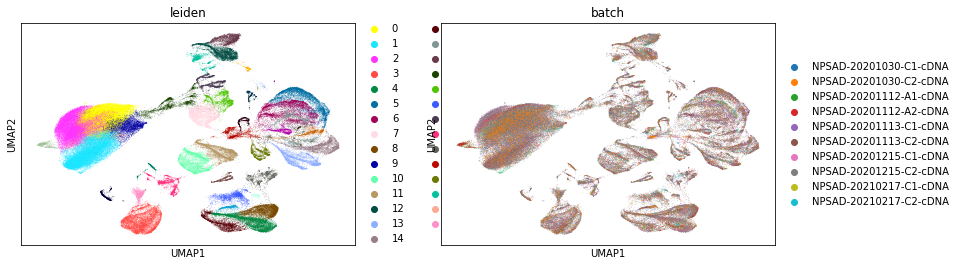

In [39]:
sc.pl.umap(adata1, color=['leiden', 'batch'], save='_10sets_SS_umap.png')

Trying to set attribute `.uns` of view, copying.


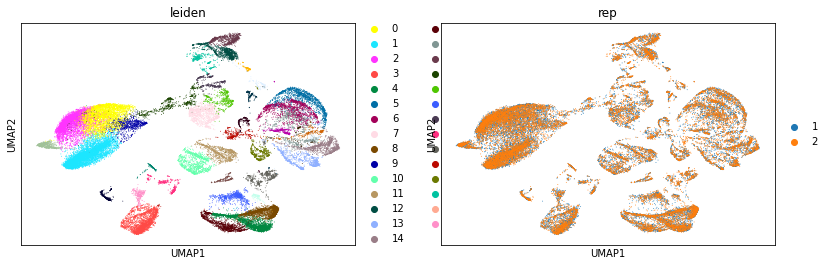

Trying to set attribute `.uns` of view, copying.


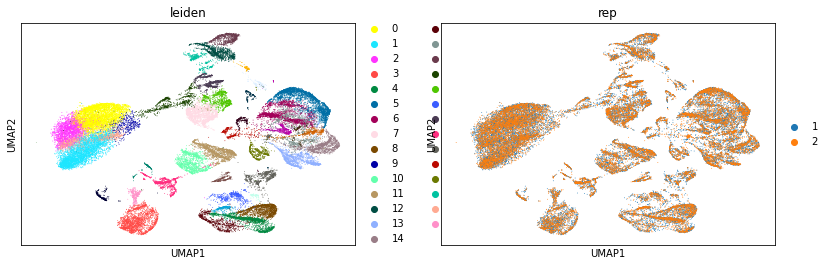

Trying to set attribute `.uns` of view, copying.


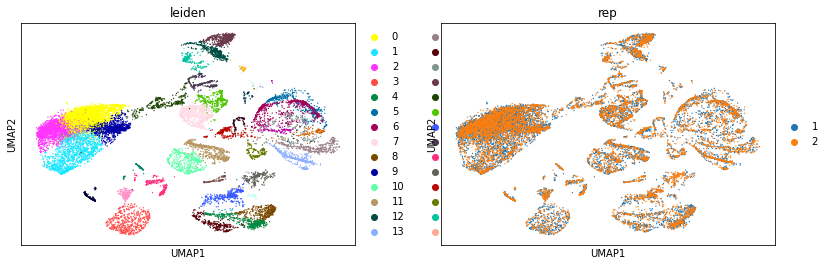

Trying to set attribute `.uns` of view, copying.


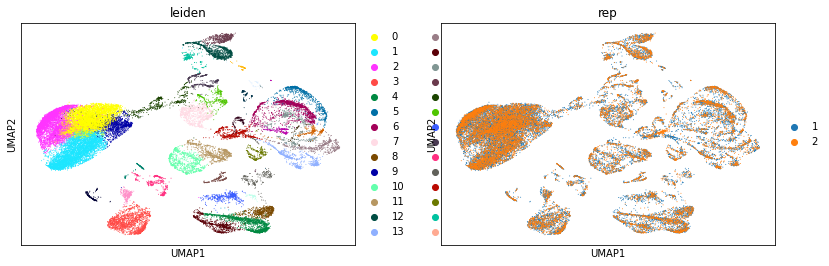

Trying to set attribute `.uns` of view, copying.


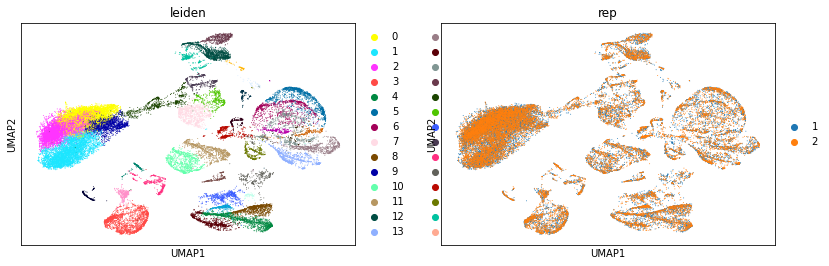

In [40]:
for sample in adata1.obs['batch_1'].unique():
    sc.pl.umap(adata1[adata1.obs['batch_1'] == sample], color=['leiden', 'rep'], save=f'_{sample}_SS_umap.png')

For cellranger output

In [70]:
adatas2 = [anndata_out(sample, "_cellR_combo_unfilt_out.h5ad", vireo_info_cr) for sample in path_samp]

In [71]:
adata2 = ad.concat(adatas2[:], index_unique='-', keys=[s.split('_')[1].replace('Sample-', '') for s in samp_l], join='inner')

In [72]:
adata2

AnnData object with n_obs × n_vars = 167247 × 26102
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'set', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'SubID_vireo', 'batch_1'

In [73]:
Counter(adata2.obs['SubID_vireo'])

Counter({'M1176': 10105,
         'Negative': 15156,
         'Doublet': 10288,
         'M76138': 5294,
         'donor3': 11066,
         'donor5': 23587,
         'donor4': 14161,
         'M45480': 2015,
         'M44145': 5474,
         'M67780': 6400,
         'M48326': 3946,
         'M34836': 4776,
         'M29736': 2364,
         'M8926': 3854,
         'M30150': 5431,
         'M55245': 6251,
         'M24257': 7299,
         'M32215': 2703,
         'M84511': 10915,
         'M9161': 3482,
         'M11589': 5922,
         'M88010': 2724,
         'M26992': 4034})

... storing 'batch' as categorical
... storing 'prep' as categorical
... storing 'rep' as categorical
... storing 'set' as categorical
... storing 'SubID_hd' as categorical
... storing 'HTO_n_hd' as categorical
... storing 'SubID_cs' as categorical
... storing 'SubID_ms' as categorical
... storing 'HTO_n_cs' as categorical
... storing 'HTO_n_ms' as categorical
... storing 'SubID_vireo' as categorical
... storing 'batch_1' as categorical
/sc/arion/work/prashf01/conda/envs/snakemake/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


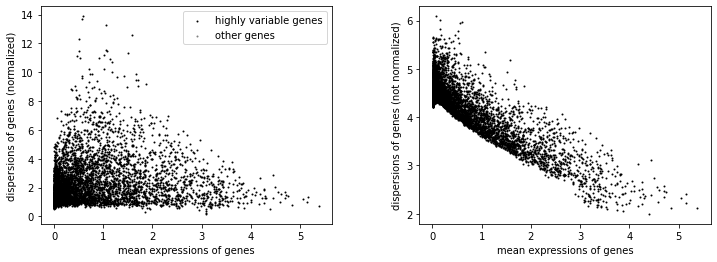

AnnData object with n_obs × n_vars = 167045 × 6000
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'set', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'SubID_vireo', 'batch_1', 'leiden', 'concurrence'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'batch_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [74]:
# Total-count normalize (library-size correct) the data matrix X to 1M i.e. CPM
sc.pp.normalize_total(adata2, target_sum=1e6)


# Logarithmize the data
sc.pp.log1p(adata2)

# Freeze the normalized data
adata2.raw = adata2

# Identify highly-variable genes, flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata2, n_top_genes=6000, flavor="cell_ranger", batch_key='batch', subset=True)
sc.pl.highly_variable_genes(adata2, save='_10sets_cr_HVG.png')

print(adata1)

In [75]:
# PCA
sc.tl.pca(adata2, svd_solver='arpack')
print("\t\t\tDone with pca")


# Run Harmony
sc.external.pp.harmony_integrate(adata2, 'batch', max_iter_harmony=20)


# Save to File
# adata.write(results_file)
print(adata2)

			Done with pca


2021-09-28 18:27:24,589 - harmonypy - INFO - Iteration 1 of 20
2021-09-28 18:28:45,600 - harmonypy - INFO - Iteration 2 of 20
2021-09-28 18:30:06,753 - harmonypy - INFO - Iteration 3 of 20
2021-09-28 18:31:27,983 - harmonypy - INFO - Iteration 4 of 20
2021-09-28 18:32:49,218 - harmonypy - INFO - Iteration 5 of 20
2021-09-28 18:34:10,596 - harmonypy - INFO - Iteration 6 of 20
2021-09-28 18:35:31,809 - harmonypy - INFO - Iteration 7 of 20
2021-09-28 18:36:53,108 - harmonypy - INFO - Iteration 8 of 20
2021-09-28 18:38:10,864 - harmonypy - INFO - Iteration 9 of 20
2021-09-28 18:38:49,019 - harmonypy - INFO - Iteration 10 of 20
2021-09-28 18:39:16,197 - harmonypy - INFO - Iteration 11 of 20
2021-09-28 18:39:43,236 - harmonypy - INFO - Iteration 12 of 20
2021-09-28 18:40:10,478 - harmonypy - INFO - Iteration 13 of 20
2021-09-28 18:40:37,765 - harmonypy - INFO - Iteration 14 of 20
2021-09-28 18:41:04,822 - harmonypy - INFO - Iteration 15 of 20
2021-09-28 18:41:32,071 - harmonypy - INFO - Iter

AnnData object with n_obs × n_vars = 167247 × 6000
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'set', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'SubID_vireo', 'batch_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'


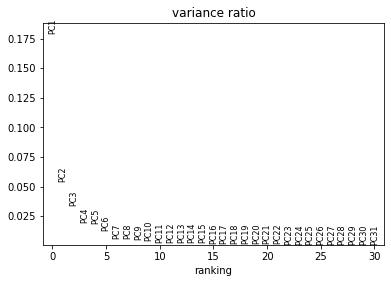

In [76]:
# Scree Plot
sc.pl.pca_variance_ratio(adata2, save='_10sets_cr_Scree_plot.png')

In [77]:
sc.pp.neighbors(adata2, use_rep='X_pca_harmony')
print("\t\t\tDone with calculating neighbours")

sc.tl.umap(adata2, min_dist=0.3)

sc.tl.leiden(adata2)


print(adata2)

			Done with calculating neighbours
AnnData object with n_obs × n_vars = 167247 × 6000
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'batch', 'round_num', 'prep', 'rep', 'set', 'SubID_hd', 'HTO_n_hd', 'SubID_cs', 'SubID_ms', 'HTO_n_cs', 'HTO_n_ms', 'SubID_vireo', 'batch_1', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


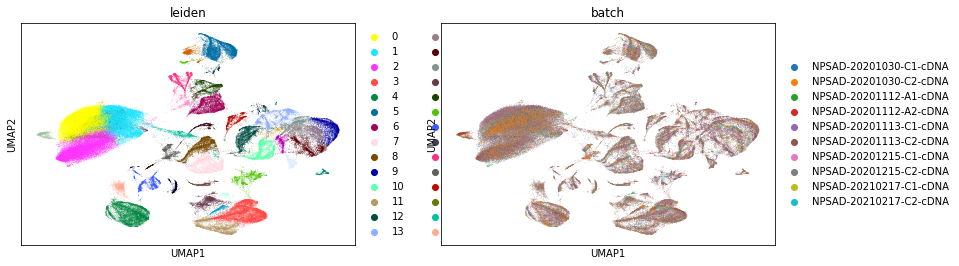

In [78]:
sc.pl.umap(adata2, color=['leiden', 'batch'], save='_10sets_cr_umap.png')

Trying to set attribute `.uns` of view, copying.


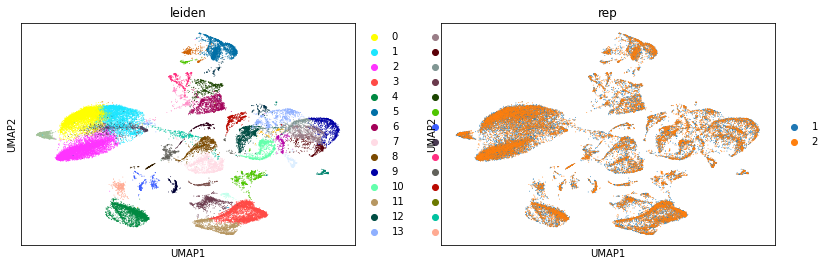

Trying to set attribute `.uns` of view, copying.


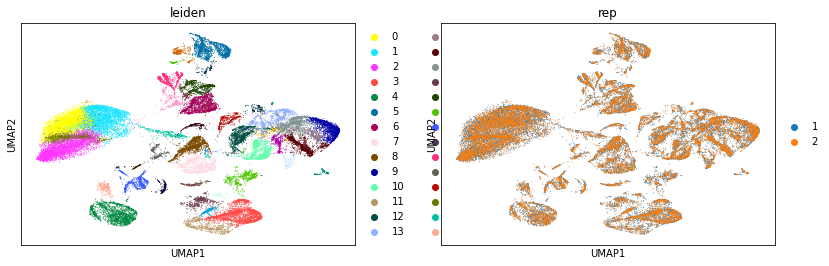

Trying to set attribute `.uns` of view, copying.


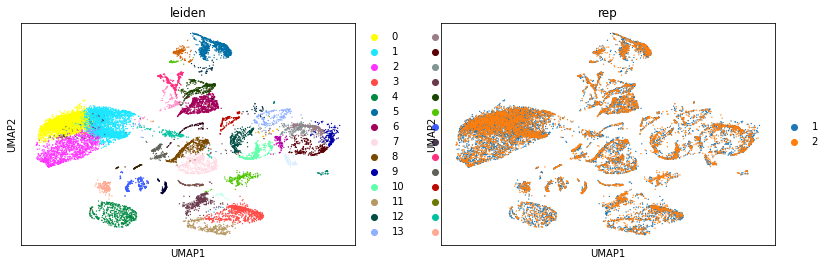

Trying to set attribute `.uns` of view, copying.


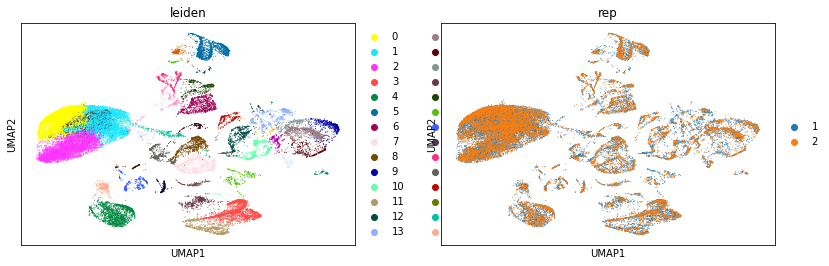

Trying to set attribute `.uns` of view, copying.


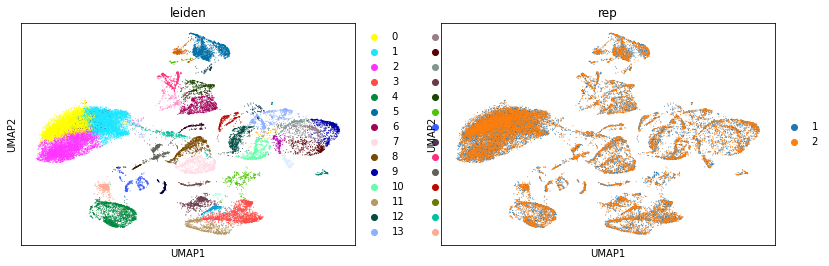

In [79]:
for sample in adata2.obs['batch_1'].unique():
    sc.pl.umap(adata2[adata2.obs['batch_1'] == sample], color=['leiden', 'rep'], save=f'_{sample}_cr_umap.png')

In [80]:
adata1.obs['concurrence'] = ret_intersections(adata1.obs['SubID_cs'], adata1.obs['SubID_ms'], adata1.obs['SubID_hd'], adata1.obs['SubID_vireo'])
adata2.obs['concurrence'] = ret_intersections(adata2.obs['SubID_cs'], adata2.obs['SubID_ms'], adata2.obs['SubID_hd'], adata2.obs['SubID_vireo'])

In [52]:
adata1.write("10sets_SS_vireoSet.h5ad")

... storing 'concurrence' as categorical


In [81]:
adata2.write("10sets_cr_vireoSet.h5ad")

... storing 'concurrence' as categorical


In [56]:
Counter(adata1[(adata1.obs['batch'] == 'NPSAD-20201112-A1-cDNA') & (adata1.obs['rep'] == '1')].obs['concurrence'])

Counter({'All': 4824,
         'CS_MS_HD': 5127,
         'No_gt_All': 6169,
         'No_gt_CS_HD': 140,
         'MS_HD': 630,
         'No_gt_CS_MS': 331,
         'No_gt_No_concurrence': 542,
         'HD_vireo': 534,
         'CS_MS_vireo': 98,
         'CS_HD': 194,
         'No_concurrence': 87,
         'CS_MS': 177,
         'CS_vireo': 101,
         'CS_HD_vireo': 33,
         'MS_vireo': 149})

In [57]:
adata1[(adata1.obs['batch_1'] == 'NPSAD-20201112-A') & (adata1.obs['rep'] == '2')].shape[0]

20037

In [58]:
Counter(adata2[(adata2.obs['batch'] == 'NPSAD-20201112-A1-cDNA') & (adata2.obs['rep'] == '1')].obs['concurrence'])

Counter({'No_vireo_All': 16402,
         'No_vireo_CS_HD': 372,
         'No_vireo_MS_HD': 1615,
         'No_vireo_CS_MS': 614,
         'No_vireo_No_concurrence': 404})

In [59]:
demux_info = []
for sample in adata1.obs['batch_1'].unique():
    temp_d = Counter(adata1[(adata1.obs['batch_1'] == sample) & (adata1.obs['rep'] == '1')].obs['concurrence'])
    tot_cells = adata1[(adata1.obs['batch_1'] == sample) & (adata1.obs['rep'] == '1')].shape[0]
    demux_info.append(( sample, '1', temp_d['All'], temp_d['CS_MS'], temp_d['CS_HD'], temp_d['MS_HD'], temp_d['CS_vireo'],
                       temp_d['MS_vireo'], temp_d['HD_vireo'], temp_d['CS_MS_HD'], temp_d['CS_HD_vireo'], temp_d['CS_MS_vireo'], temp_d['MS_HD_vireo'],
                      temp_d['No_concurrence'], temp_d['No_vireo_All'], temp_d['No_vireo_CS_MS'], temp_d['No_vireo_CS_HD'], 
                       temp_d['No_vireo_MS_HD'], temp_d['No_vireo_No_concurrence'], temp_d['No_gt_No_concurrence'], temp_d['No_gt_All'], temp_d['No_gt_CS_MS'], 
                      temp_d['No_gt_CS_HD'], temp_d['No_gt_MS_HD'], tot_cells ))
    
    temp_d = Counter(adata1[(adata1.obs['batch_1'] == sample) & (adata1.obs['rep'] == '2')].obs['concurrence'])
    tot_cells = adata1[(adata1.obs['batch_1'] == sample) & (adata1.obs['rep'] == '2')].shape[0]
    demux_info.append(( sample, '2', temp_d['All'], temp_d['CS_MS'], temp_d['CS_HD'], temp_d['MS_HD'], temp_d['CS_vireo'],
                       temp_d['MS_vireo'], temp_d['HD_vireo'],temp_d['CS_MS_HD'], temp_d['CS_HD_vireo'], temp_d['CS_MS_vireo'], temp_d['MS_HD_vireo'],
                      temp_d['No_concurrence'], temp_d['No_vireo_All'], temp_d['No_vireo_CS_MS'], temp_d['No_vireo_CS_HD'], 
                       temp_d['No_vireo_MS_HD'], temp_d['No_vireo_No_concurrence'], temp_d['No_gt_No_concurrence'], temp_d['No_gt_All'], temp_d['No_gt_CS_MS'], 
                      temp_d['No_gt_CS_HD'], temp_d['No_gt_MS_HD'], tot_cells ))
    

demux_df = pd.DataFrame(demux_info, columns=['Set', 'Rep', 'Concurrence', 'CS_MS', 'CS_HD', 'MS_HD', 'CS_vireo', 'MS_vireo', 'HD_vireo', 
                                             'CS_MS_HD', 'CS_HD_vireo', 'CS_MS_vireo', 'MS_HD_vireo', 'No_4_concurrence', 'Not_vireo_3',
                                             'Not_vireo_CS_MS', 'Not_vireo_CS_HD', 'Not_vireo_MS_HD', 'Not_vireo_No_concurrence', 
                                             'No_gt_No_concurrence', 'No_gt_All', 'No_gt_CS_MS', 'No_gt_CS_HD', 'No_gt_MS_HD', 'Total_cells'])
demux_df.to_csv("Demux_info_10Sets_SS_Vireo.tsv", sep = "\t", index=False)


In [82]:
demux_info = []
for sample in adata2.obs['batch_1'].unique():
    temp_d = Counter(adata2[(adata2.obs['batch_1'] == sample) & (adata2.obs['rep'] == '1')].obs['concurrence'])
    tot_cells = adata2[(adata2.obs['batch_1'] == sample) & (adata2.obs['rep'] == '1')].shape[0]
    demux_info.append(( sample, '1', temp_d['All'], temp_d['CS_MS'], temp_d['CS_HD'], temp_d['MS_HD'], temp_d['CS_vireo'],
                       temp_d['MS_vireo'], temp_d['HD_vireo'], temp_d['CS_MS_HD'], temp_d['CS_HD_vireo'], temp_d['CS_MS_vireo'], temp_d['MS_HD_vireo'],
                      temp_d['No_concurrence'], temp_d['No_vireo_All'], temp_d['No_vireo_CS_MS'], temp_d['No_vireo_CS_HD'], 
                       temp_d['No_vireo_MS_HD'], temp_d['No_vireo_No_concurrence'], temp_d['No_gt_No_concurrence'], temp_d['No_gt_All'], temp_d['No_gt_CS_MS'], 
                      temp_d['No_gt_CS_HD'], temp_d['No_gt_MS_HD'], tot_cells ))
    
    temp_d = Counter(adata2[(adata2.obs['batch_1'] == sample) & (adata2.obs['rep'] == '2')].obs['concurrence'])
    tot_cells = adata2[(adata2.obs['batch_1'] == sample) & (adata2.obs['rep'] == '2')].shape[0]
    demux_info.append(( sample, '2', temp_d['All'], temp_d['CS_MS'], temp_d['CS_HD'], temp_d['MS_HD'], temp_d['CS_vireo'],
                       temp_d['MS_vireo'], temp_d['HD_vireo'],temp_d['CS_MS_HD'], temp_d['CS_HD_vireo'], temp_d['CS_MS_vireo'], temp_d['MS_HD_vireo'],
                      temp_d['No_concurrence'], temp_d['No_vireo_All'], temp_d['No_vireo_CS_MS'], temp_d['No_vireo_CS_HD'], 
                       temp_d['No_vireo_MS_HD'], temp_d['No_vireo_No_concurrence'], temp_d['No_gt_No_concurrence'], temp_d['No_gt_All'], temp_d['No_gt_CS_MS'], 
                      temp_d['No_gt_CS_HD'], temp_d['No_gt_MS_HD'], tot_cells ))
    

demux_df = pd.DataFrame(demux_info, columns=['Set', 'Rep', 'Concurrence', 'CS_MS', 'CS_HD', 'MS_HD', 'CS_vireo', 'MS_vireo', 'HD_vireo', 
                                             'CS_MS_HD', 'CS_HD_vireo', 'CS_MS_vireo', 'MS_HD_vireo', 'No_4_concurrence', 'Not_vireo_3',
                                             'Not_vireo_CS_MS', 'Not_vireo_CS_HD', 'Not_vireo_MS_HD', 'Not_vireo_No_concurrence', 
                                             'No_gt_No_concurrence', 'No_gt_All', 'No_gt_CS_MS', 'No_gt_CS_HD', 'No_gt_MS_HD', 'Total_cells'])
demux_df.to_csv("Demux_info_10Sets_cr_Vireo.tsv", sep = "\t", index=False)

In [42]:
#adata_combo = ad.concat([adata1, adata2], index_unique='-', label='prog', keys=['STARsolo', 'cellranger'], join='inner')

In [43]:
#adata_combo.write("10sets_SS_cr_vireoSet.h5ad")